In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
import statistics
import seaborn as sns
from skbio.stats.composition import multiplicative_replacement
from skbio.stats.composition import clr
from tqdm import tqdm

In [2]:
healthyNetwork = nx.read_gexf("./Files/Networks/healthyNetwork_168.gexf")
crcNetwork = nx.read_gexf("./Files/Networks/crcNetwork_168.gexf")

In [3]:
accTaxDictDF = pd.read_csv("./Files/Dataframes/Master_Rename.csv").set_index("Bacterial_Strain")
accTaxDictDF['Species'] = accTaxDictDF['Species'].astype(str)
accTaxDictDF.head()

accTaxDictDF2 = accTaxDictDF.reset_index().set_index("Species").copy()

accTaxDictDF3 = accTaxDictDF2.loc[~accTaxDictDF2.index.duplicated(keep='first')].copy()

In [4]:
def inspectNodes(df):
    df2 = df.copy()
    
    generaList = []

    for i in list(df2.index):
        generaList.append((accTaxDictDF3.at[i.replace(".","-"), 'Genus']))
    
    generaList2 = list(set(generaList))

    tempDF = pd.DataFrame(index=generaList2, columns=['Healthy','CRC'])
    tempDF.fillna(0, inplace=True)

    for i in tempDF.columns:
        for x in df2[df2['Cohort']==i].dropna().index:
            tempDF.at[str(accTaxDictDF3.at[x.replace(".","-"), 'Genus']), i] += 1
            
    tempDF['Healthy'] = tempDF[['Healthy']].div(tempDF[['Healthy']].sum())
    tempDF['CRC'] = tempDF[['CRC']].div(tempDF[['CRC']].sum())
    
    orderList = sorted(list(tempDF.index))
    
    tempDF2 = tempDF.loc[orderList].T.copy()
            
    return (tempDF2)

In [5]:
def inspectNodesGenusCount(df):
    df2 = df.copy()
    
    generaList = []

    for i in list(df2.index):
        generaList.append((accTaxDictDF3.at[i.replace(".","-"), 'Genus']))
    
    generaList2 = list(set(generaList))

    tempDF = pd.DataFrame(index=generaList2, columns=['Healthy','CRC'])
    tempDF.fillna(0, inplace=True)

    for i in tempDF.columns:
        for x in df2[i].dropna().index:
            tempDF.at[str(accTaxDictDF3.at[x.replace(".","-"), 'Genus']), i] += 1
    
    orderList = sorted(list(tempDF.index))
    
    tempDF2 = tempDF.loc[orderList].T.copy()
            
    return (tempDF2)

In [6]:
def inspectNodesSpecies(df):
    df2 = df.copy()
    
    generaList = []

    for i in list(df2.index):
        generaList.append(i)
    
    generaList2 = list(set(generaList))

    tempDF = pd.DataFrame(index=generaList2, columns=['Healthy','CRC'])
    tempDF.fillna(0, inplace=True)

    for i in tempDF.columns:
        for x in df2[df2['Cohort']==i].dropna().index:
            tempDF.at[str(x), i] += 1
    
    orderList = sorted(list(tempDF.index))
    
    tempDF2 = tempDF.loc[orderList].T.copy()
            
    return (tempDF2)

## Import Functional Potential DataFrame

In [7]:
#The variable says pfam but I just point it to TIGRFAM csv to save time running for protein families
crcSF_pfam = pd.read_csv("./Files/Dataframes/Functional/crcSpecies_TIGRFAMs.csv")
healthtySF_pfam = pd.read_csv("./Files/Dataframes/Functional/japaneseSpecies_TIGRFAMs.csv")

crcSF_pfam.rename(columns={'Unnamed: 0':'Bacterial_Species'}, inplace=True)
healthtySF_pfam.rename(columns={'Unnamed: 0':'Bacterial_Species'}, inplace=True)

crcSF_pfam.set_index("Bacterial_Species", inplace=True)
healthtySF_pfam.set_index("Bacterial_Species", inplace=True)

## Load Node DataFrames for all Countries

In [8]:
healthyDF = pd.read_csv('./Files/Dataframes/healthy_Node_properties_168.csv').set_index("Bacterial_Species").sort_values(by='Degree_Centrality', ascending=False)
crcDF = pd.read_csv('./Files/Dataframes/crc_Node_properties_168.csv').set_index("Bacterial_Species").sort_values(by='Degree_Centrality', ascending=False)

In [9]:
allNodeDF = pd.concat([healthyDF, crcDF])
allNodeDF_pos = allNodeDF[allNodeDF['Negative_Edges']==0].copy()

## Load partitions

In [10]:
crcPartitions_temp = set(line.strip() for line in open('./Files/Networks/crcPartitions_168.txt'))
healthyPartitions_temp = set(line.strip() for line in open('./Files/Networks/healthyPartitions_168.txt'))

crcPartitions = []
healthyPartitions = []

for x in crcPartitions_temp:
        tempSet = list()
        for y in x.split(","):
            tempSet.append(y.split("'")[1])
        crcPartitions.append(set(tempSet))     
        
for x in healthyPartitions_temp:
        tempSet = list()
        for y in x.split(","):
            tempSet.append(y.split("'")[1])
        healthyPartitions.append(set(tempSet)) 

## Look at PCA and then look at Feature Importance

In [11]:
def pullTopFeatures(df, pc):
    tempDictionary = {"PFAM":[], "Feature_Importance":[]}
    df1 = df.copy()
    df2 = df1.T.reindex(featureImportanceDF_Pfam.T[pc].abs().sort_values(ascending=False).index).copy()
    posCount = 0
    negCount = 0
    
    for row in df2.index:
        if df2.at[row,pc] > 0 and posCount < 10:
            tempDictionary["PFAM"].append(row)
            tempDictionary["Feature_Importance"].append(df2.at[row,pc])
            posCount +=1
            
        elif df2.at[row,pc] < 0 and negCount < 10:
            tempDictionary["PFAM"].append(row)
            tempDictionary["Feature_Importance"].append(df2.at[row,pc])
            negCount +=1
        
        else:
            continue
    
    tempDF = pd.DataFrame(data=tempDictionary)
    return(tempDF.set_index("PFAM").sort_values(by="Feature_Importance", ascending=False))

## Now Look at Designated Node Partner Functionalities 

In [12]:
def labelModules(partition, cohort):
    tempDict = {}
    countt = 0
    for i in partition:
        if len(i) > 2:
            tempDict[cohort+"_Module_"+str(countt)] = i
            countt +=1
        
    return (tempDict)

In [13]:
crcModuleLabel = labelModules(crcPartitions, "CRC")
healthyModuleLabel = labelModules(healthyPartitions, "Healthy")

In [14]:
def buildCommunityNodes(comList, cohortFunctionality, cohortName):
    
    tempDF = pd.DataFrame(columns=cohortFunctionality.columns)
    
    i = 0
    for module in list(comList.keys()):
        tempDF.loc[module] = cohortFunctionality.loc[comList[module]].sum().copy()
        i+=1
    
    tempDF['Cohort'] = cohortName
    
    return tempDF

In [15]:
def buildWeightedModuleNodes(comList, cohortFunctionality, cohortAbundance, cohortName):
    
    tempDF = pd.DataFrame(columns=cohortFunctionality.columns, index=list(comList.keys()))
    tempDF.fillna(0.0, inplace=True)
    
    for module in comList:
        summ = 0.0
        tempDict = {}
        
        for species in comList[module]:
            tempDict[species] = cohortAbundance[species].mean()
            summ += cohortAbundance[species].mean()
        
        for bacteria in comList[module]:
            tempDF.loc[module] += (cohortFunctionality.loc[bacteria]) * (tempDict[bacteria]/summ)
    
    tempDF['Cohort'] = cohortName
    
    return tempDF

In [16]:
healthySpeciesALLDF = pd.read_csv("./Files/Dataframes/speciesDataframes/masterJapanese_allSpecies.csv").set_index("SampleName")
crcSpeciesALLDF = pd.read_csv("./Files/Dataframes/speciesDataframes/masterCRC_allSpecies.csv").set_index("SampleName")

healthySpeciesALLDF.replace(0.0, np.nan, inplace=True)
crcSpeciesALLDF.replace(0.0, np.nan, inplace=True)

In [17]:
crcModules = buildWeightedModuleNodes(crcModuleLabel, crcSF_pfam, crcSpeciesALLDF, 'CRC')
healthyModules = buildWeightedModuleNodes(healthyModuleLabel, healthtySF_pfam, healthySpeciesALLDF, 'Healthy')

In [18]:
#Unweighted version
#crcModules = buildCommunityNodes(crcModuleLabel, crcSF_pfam, 'CRC')
#healthyModules = buildCommunityNodes(healthyModuleLabel, healthtySF_pfam, 'Healthy')

In [19]:
allModules = pd.concat([crcModules,healthyModules])
#Label the index so the PCA code doesnt have to be changed. Im lazy I know. 
allModules.index.name = 'Bacterial_Species'
allMDF1 = allModules.copy()
allMDF2 = allMDF1.drop(columns=['Cohort']).copy()
allMDF2.replace(0.0, np.nan, inplace=True)
allMDF2.dropna(axis=1, thresh=1, inplace=True)
allMDF2.fillna(0.0, inplace=True)
allMDF3 = allMDF2.copy()

for row in allMDF3.index:
    allMDF3.loc[row] = clr(np.array(allMDF2.loc[row].replace(0.0, 1e-10)))
allMDF3['Cohort'] = allMDF1['Cohort']
allMDF3.head()

,TIGR02778,TIGR00283,TIGR02100,TIGR02359,TIGR00224,TIGR00745,TIGR00260,TIGR04171,TIGR04342,TIGR01852,...,TIGR01819,TIGR01673,TIGR02366,TIGR01832,TIGR00100,TIGR01295,TIGR03494,TIGR01733,TIGR00967,Cohort
Bacterial_Species,,,,,,,,,,,,,,,,,,,,,
CRC_Module_0,-7.503506,-7.503506,3.648459,-7.503506,8.542272,8.539811,8.542272,-7.503506,-7.503506,8.927954,...,-7.503506,-7.503506,-7.503506,-7.503506,-7.503506,-7.503506,-7.503506,7.725033,8.542272,CRC
CRC_Module_1,-10.945334,-10.945334,2.278166,4.323762,4.748505,4.432463,5.119794,-10.945334,-10.945334,2.954899,...,-10.945334,3.606835,-10.945334,-0.433992,-10.945334,-10.945334,-10.945334,4.624636,5.294042,CRC
CRC_Module_2,-7.190143,-7.190143,-7.190143,-7.190143,8.966000,8.966000,8.966000,-7.190143,-7.190143,9.078533,...,-7.190143,-7.190143,-7.190143,-7.190143,-7.190143,-7.190143,-7.190143,5.188818,8.966000,CRC
CRC_Module_3,5.931263,-8.043830,-8.043830,-8.043830,7.827475,7.664796,8.202086,-8.043830,-8.043830,-8.043830,...,-8.043830,-8.043830,-8.043830,-8.043830,-8.043830,-8.043830,-8.043830,5.931263,8.202086,CRC
CRC_Module_4,-7.724917,-7.724917,-7.724917,6.974838,-7.724917,6.842263,8.183027,8.183027,8.483886,6.974838,...,-7.724917,-7.724917,-7.724917,-7.724917,-7.724917,-7.724917,-7.724917,8.735966,8.830864,CRC


In [20]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def runPCA(dataframe, filename, title):
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop("Cohort", axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    import seaborn as sns
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 11.7,8.27
    palette ={"Healthy":'green', "CRC":'red'}

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1 ('+str("%.2f" % (100*pca.explained_variance_ratio_[0]))+"% variance)", labelpad=15)
    ax.set_ylabel('Principal Component 2 ('+str("%.2f" % (100*pca.explained_variance_ratio_[1]))+"% variance)", labelpad=15)
    ax.set_title('Principal Component Analysis ('+title+')')

    targets = ['Healthy','CRC']

    colors = ['green','red']
    
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf ['Cohort'] == target
        ax.scatter(finalDf .loc[indicesToKeep, 'principal component 1']
                   , finalDf .loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(targets, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='Cohorts')
    rcParams['figure.figsize'] = 11.7,8.27
    ax = sns.set(font_scale=1.5)
    #plt.savefig("/home/mark/Desktop/"+filename+".png", dpi=300, bbox_inches='tight')
    #plt.savefig("/home/mark/Desktop/"+filename+".svg", dpi=300, bbox_inches='tight')
    #plt.savefig("/home/mark/Desktop/"+filename+".pdf", dpi=300, bbox_inches='tight')
    plt.show()

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def runPCA2(dataframe, filename, title):
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(["Cohort","Designation"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    import seaborn as sns
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 11.7,8.27
    palette ={"Healthy":'green', "CRC":'red'}

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1 ('+str("%.2f" % (100*pca.explained_variance_ratio_[0]))+"% variance)", labelpad=15)
    ax.set_ylabel('Principal Component 2 ('+str("%.2f" % (100*pca.explained_variance_ratio_[1]))+"% variance)", labelpad=15)
    ax.set_title('Principal Component Analysis ('+title+')', y=1.03)

    targets = ['Healthy','CRC']

    colors = ['green','red']
    
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf ['Cohort'] == target
        ax.scatter(finalDf .loc[indicesToKeep, 'principal component 1']
                   , finalDf .loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50, alpha=.5)
    ax.legend(targets, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='Cohorts')
    rcParams['figure.figsize'] = 11.7,8.27
    ax = sns.set(font_scale=1.5)
    #plt.savefig("/home/mark/Desktop/"+filename+".png", bbox_inches='tight', dpi=300)
    plt.show()

In [22]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pullFeatureImportance(dataframe):
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(columns=["Cohort"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    
    return (pd.DataFrame(pca.components_,columns=pcaDF3.columns,index = ['PC-1','PC-2']))

In [23]:
def pullTopFeatures(df, pc):
    tempDictionary = {"PFAM":[], "Feature_Importance":[]}
    df1 = df.copy()
    df2 = df1.T.reindex(featureImportanceDF_TIGRFAM.T[pc].abs().sort_values(ascending=False).index).copy()
    posCount = 0
    negCount = 0
    
    for row in df2.index:
        if df2.at[row,pc] > 0 and posCount < 10:
            tempDictionary["PFAM"].append(row)
            tempDictionary["Feature_Importance"].append(df2.at[row,pc])
            posCount +=1
            
        elif df2.at[row,pc] < 0 and negCount < 10:
            tempDictionary["PFAM"].append(row)
            tempDictionary["Feature_Importance"].append(df2.at[row,pc])
            negCount +=1
        
        else:
            continue
    
    tempDF = pd.DataFrame(data=tempDictionary)
    return(tempDF.set_index("PFAM").sort_values(by="Feature_Importance", ascending=False))

In [24]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pullNodeArea(dataframe):
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(columns=["Cohort","Designation"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort','Designation']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort','Designation']]], axis = 1).copy()
    
    tempDict = {"Bacterial_Species":[], "Cohort":[], "PC1":[], "PC2":[]}
    
    for x in finalDf.index:
        tempDict['Bacterial_Species'].append(list(dataframe.index)[x])
        tempDict['Cohort'].append(finalDf.at[x,'Cohort'])
        tempDict['PC1'].append(finalDf.at[x,'principal component 1'])
        tempDict['PC2'].append(finalDf.at[x,'principal component 2'])
    
    
    tempDF = pd.DataFrame(data=tempDict).set_index("Bacterial_Species")
    
    tempDict2 = {"Cohort":[], "LeftSide":[], "RightSide":[]}
    
    for y in list(set(tempDF['Cohort'])):
        tempDict2['Cohort'].append(y)
        tempDict2['LeftSide'].append(len([i for i in list(tempDF[tempDF["Cohort"]==y]['PC1']) if i < 0]))
        tempDict2['RightSide'].append(len([i for i in list(tempDF[tempDF["Cohort"]==y]['PC1']) if i > 0]))
    
    tempDF2 = pd.DataFrame(data=tempDict2).set_index("Cohort")
    
    return tempDF2

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pullNodeModuleArea(dataframe):
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(columns=["Cohort"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    
    tempDict = {"Bacterial_Species":[], "PC1":[], "PC2":[]}
    
    for x in finalDf.index:
        tempDict['Bacterial_Species'].append(list(dataframe.index)[x])
        tempDict['PC1'].append(finalDf.at[x,'principal component 1'])
        tempDict['PC2'].append(finalDf.at[x,'principal component 2'])
    
    tempDF = pd.DataFrame(data=tempDict).set_index("Bacterial_Species")

    tempDict2 = {"Module":[], "Left_Cluster":[], "Right_Cluster":[], "Top_Cluster":[], "Bottom_Cluster":[]}
    
    for y in tempDF.index:
        tempDict2['Module'].append(y)
        if float(tempDF.at[y,'PC2']) > 100:
            tempDict2['Top_Cluster'].append(1)
            tempDict2['Left_Cluster'].append(np.nan)
            tempDict2['Right_Cluster'].append(np.nan)
            tempDict2['Bottom_Cluster'].append(np.nan)
        elif float(tempDF.at[y,'PC2']) < 50 and float(tempDF.at[y,'PC1']) < -90: 
            tempDict2['Top_Cluster'].append(np.nan)
            tempDict2['Left_Cluster'].append(1)
            tempDict2['Right_Cluster'].append(np.nan)
            tempDict2['Bottom_Cluster'].append(np.nan)
        elif float(tempDF.at[y,'PC2']) < -80 and float(tempDF.at[y,'PC1']) > -90: 
            tempDict2['Top_Cluster'].append(np.nan)
            tempDict2['Left_Cluster'].append(np.nan)
            tempDict2['Right_Cluster'].append(np.nan)
            tempDict2['Bottom_Cluster'].append(1)
        else:
            tempDict2['Top_Cluster'].append(np.nan)
            tempDict2['Left_Cluster'].append(np.nan)
            tempDict2['Right_Cluster'].append(1)
            tempDict2['Bottom_Cluster'].append(np.nan)
    
    tempDF2 = pd.DataFrame(data=tempDict2).set_index("Module")
    
    return tempDF2

In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pullNodeModuleArea_5Clusters(dataframe):
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(columns=["Cohort"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    
    tempDict = {"Bacterial_Species":[], "PC1":[], "PC2":[]}
    
    for x in finalDf.index:
        tempDict['Bacterial_Species'].append(list(dataframe.index)[x])
        tempDict['PC1'].append(finalDf.at[x,'principal component 1'])
        tempDict['PC2'].append(finalDf.at[x,'principal component 2'])
    
    tempDF = pd.DataFrame(data=tempDict).set_index("Bacterial_Species")

    tempDict2 = {"Module":[], "Cluster_1":[], "Cluster_2":[], "Cluster_3":[], "Cluster_4":[], "Cluster_5":[]}
    
    for y in tempDF.index:
        tempDict2['Module'].append(y)
        if float(tempDF.at[y,'PC2']) < 0 and float(tempDF.at[y,'PC1']) < -100:
            tempDict2['Cluster_1'].append(1)
            tempDict2['Cluster_2'].append(np.nan)
            tempDict2['Cluster_3'].append(np.nan)
            tempDict2['Cluster_4'].append(np.nan)
            tempDict2['Cluster_5'].append(np.nan)
        elif float(tempDF.at[y,'PC2']) > 100 and float(tempDF.at[y,'PC2']) < 250 and float(tempDF.at[y,'PC1']) < -100: 
            tempDict2['Cluster_1'].append(np.nan)
            tempDict2['Cluster_2'].append(1)
            tempDict2['Cluster_3'].append(np.nan)
            tempDict2['Cluster_4'].append(np.nan)
            tempDict2['Cluster_5'].append(np.nan)
        elif float(tempDF.at[y,'PC2']) > 250: 
            tempDict2['Cluster_1'].append(np.nan)
            tempDict2['Cluster_2'].append(np.nan)
            tempDict2['Cluster_3'].append(1)
            tempDict2['Cluster_4'].append(np.nan)
            tempDict2['Cluster_5'].append(np.nan)
        elif float(tempDF.at[y,'PC1']) > 200:
            tempDict2['Cluster_1'].append(np.nan)
            tempDict2['Cluster_2'].append(np.nan)
            tempDict2['Cluster_3'].append(np.nan)
            tempDict2['Cluster_4'].append(1)
            tempDict2['Cluster_5'].append(np.nan)
        else:
            tempDict2['Cluster_1'].append(np.nan)
            tempDict2['Cluster_2'].append(np.nan)
            tempDict2['Cluster_3'].append(np.nan)
            tempDict2['Cluster_4'].append(np.nan)
            tempDict2['Cluster_5'].append(1)
    
    tempDF2 = pd.DataFrame(data=tempDict2).set_index("Module")
    
    return tempDF2

## LOOK AT PCA

In [27]:
moduelClusterDF = pullNodeModuleArea_5Clusters(allMDF3)

import dill
import pickle
f = open("./Files/Networks/Modules/Healthy_modules.pkl","wb")
pickle.dump(healthyModuleLabel,f)
f.close()

f = open("./Files/Networks/Modules/CRC_modules.pkl","wb")
pickle.dump(crcModuleLabel,f)
f.close()

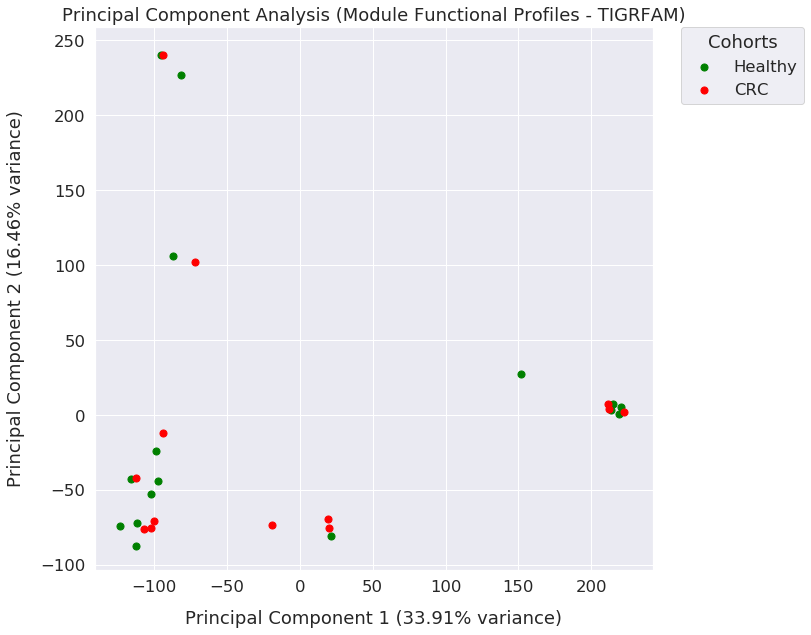

In [29]:
runPCA(allMDF3, 'TIGRFAMMODULES', 'Module Functional Profiles - TIGRFAM')

In [33]:
tempDf = allMDF3.copy()
tempDf['Designation']='Temp'

## Cluster Module Functional Profiles

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def runPCA3(dataframe, filename, title):
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(["Cohort","Designation"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    finalDf['Organism'] = list(dataframe.index)
    
    return(finalDf)

## KMeans

In [36]:
tempcomp = runPCA3(tempDf, 'Degree_all_Nodes_Pfam', 'High Degree Centrality - TIGRFAM')
tempcomp.sort_values(by='principal component 1', ascending=False)

,principal component 1,principal component 2,Cohort,Organism
0,222.625559,2.296760,CRC,CRC_Module_0
14,220.370204,5.054367,Healthy,Healthy_Module_1
28,219.259246,0.649439,Healthy,Healthy_Module_15
15,215.344962,7.138471,Healthy,Healthy_Module_2
17,213.491058,3.628951,Healthy,Healthy_Module_4
2,212.410346,3.927706,CRC,CRC_Module_2
8,211.859365,7.638426,CRC,CRC_Module_8
23,151.595802,27.299777,Healthy,Healthy_Module_10
27,21.622122,-80.670726,Healthy,Healthy_Module_14
5,19.869075,-75.185718,CRC,CRC_Module_5


In [37]:
pcaClusterDF = tempcomp.set_index("Organism").drop(columns=['Cohort']).copy()

For n_clusters = 2 The average silhouette_score is : 0.6488884599049026
For n_clusters = 3 The average silhouette_score is : 0.7503973709881117
For n_clusters = 4 The average silhouette_score is : 0.7650651935141504
For n_clusters = 5 The average silhouette_score is : 0.8156018138880125
For n_clusters = 6 The average silhouette_score is : 0.7371558784390276


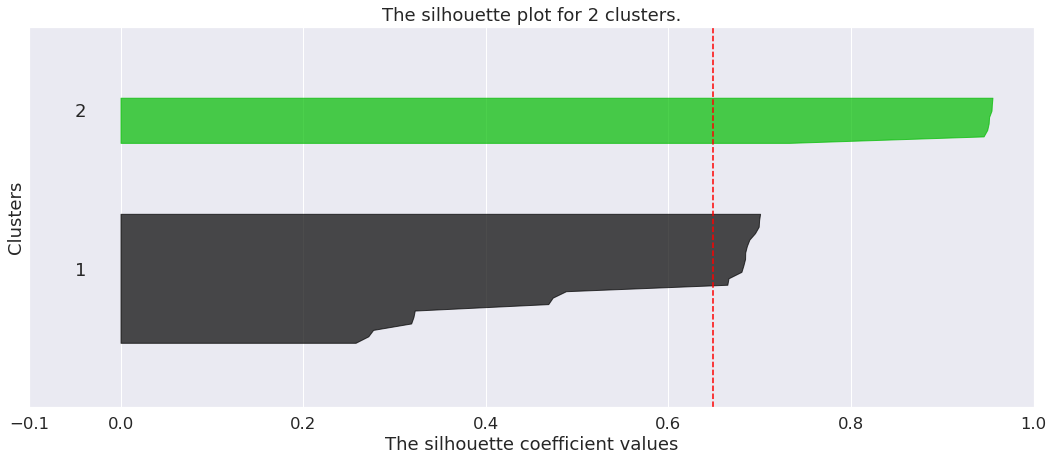

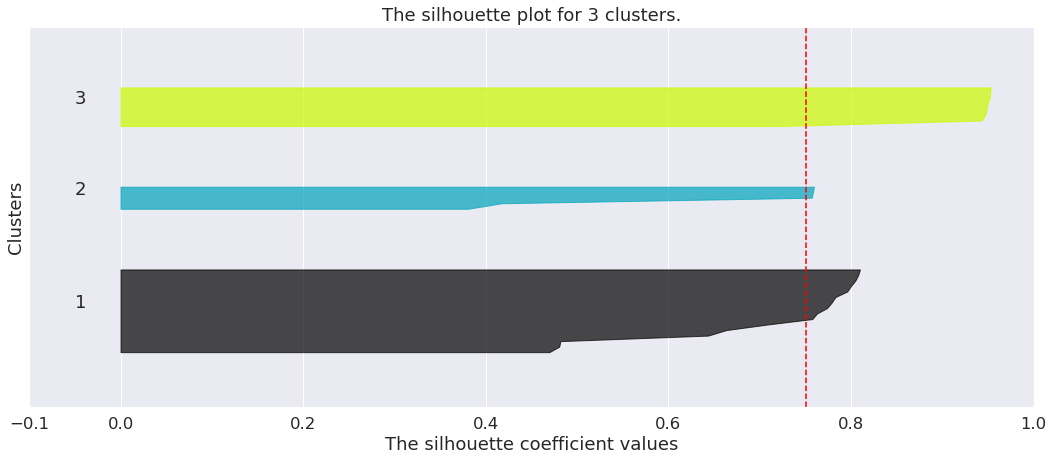

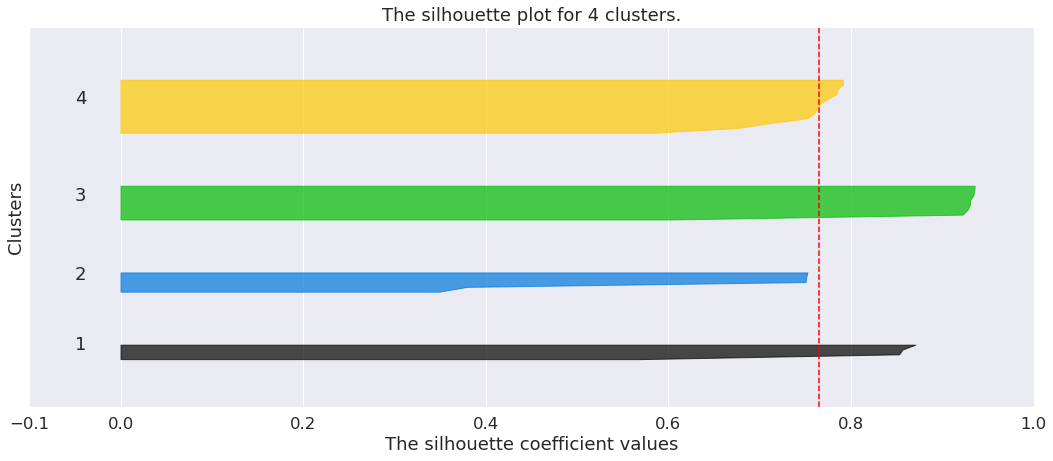

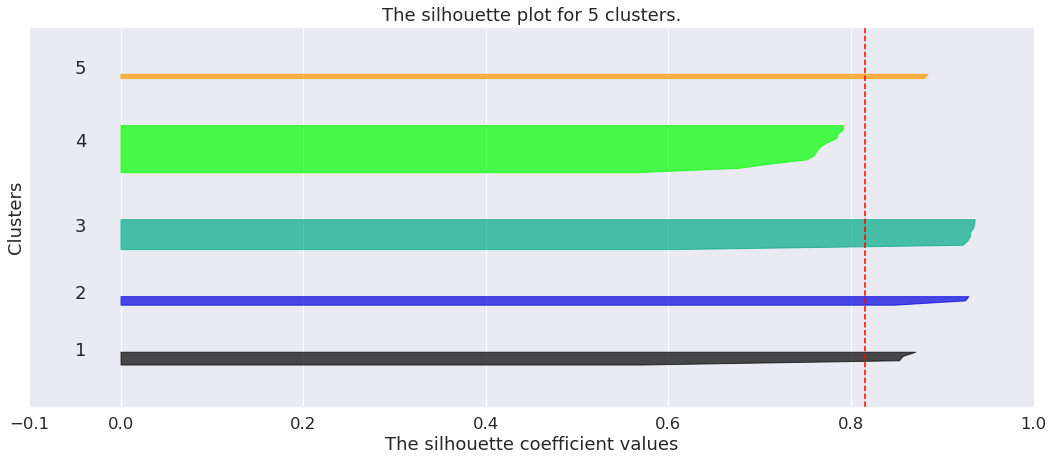

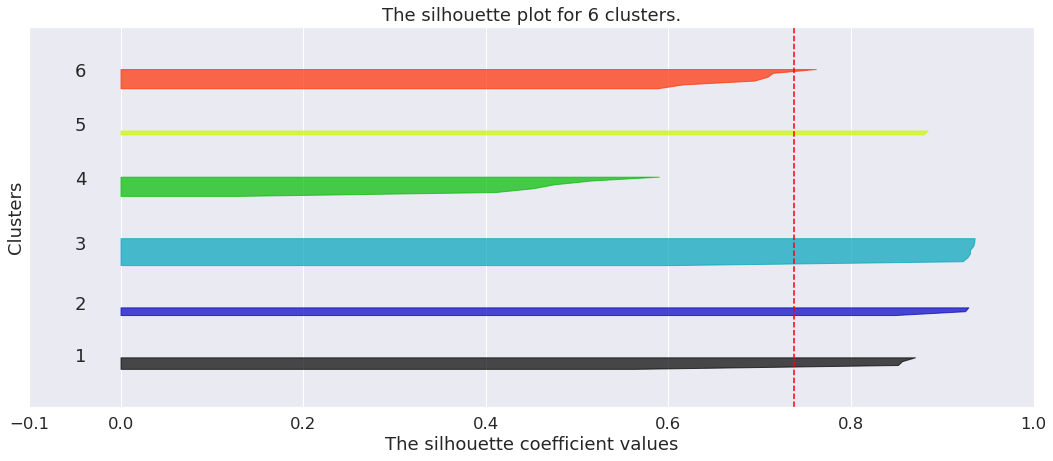

In [38]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]

X = pcaClusterDF.copy()

KScores = {}
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    KScores[n_clusters]=silhouette_avg
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for "+str(i+1)+" clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Clusters")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    #plt.savefig("/home/Silhouette_PCA_Modules_"+str(i)+".pdf", bbox_inches='tight', dpi=300)

plt.show()



([<matplotlib.axis.XTick at 0x7fdb6352c240>,
 <a list of 5 Text xticklabel objects>)

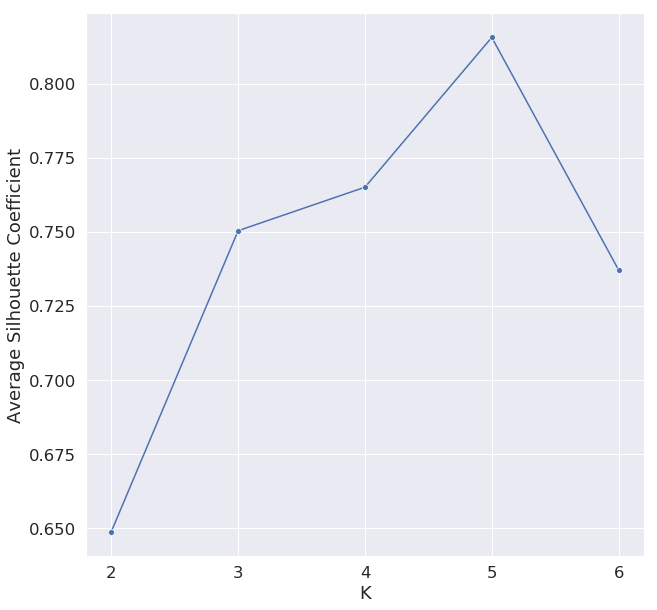

In [39]:
plt.subplots(figsize=(10,10))
kDF = pd.DataFrame(columns=['K','Average Silhouette Coefficient'])
kDF['K'] = KScores.keys()
kDF['Average Silhouette Coefficient'] = KScores.values()
sns.lineplot(data=kDF, x="K", y="Average Silhouette Coefficient", marker='o')
plt.xticks(np.arange(min(list(kDF['K'])), max(list(kDF['K']))+1, 1.0))
#plt.savefig("Silhouette_K_LineGraph.pdf", bbox_inches='tight', dpi=300)

In [40]:
#Give random state so reproducible
clustering = KMeans(n_clusters=5, random_state=8).fit(pcaClusterDF)

pcaClusterDF['Km'] = clustering.labels_
pcaClusterDF['Clusters'] = 'temp'

for i in pcaClusterDF.index:
    pcaClusterDF.at[i,'Clusters'] = str("Cluster: ")+str(pcaClusterDF.at[i,'Km']+1)

In [41]:
pcaClusterDF2 = pcaClusterDF.drop(columns=['Km']).copy()
pcaClusterDF2['Cluster'] = 'temp'
for i in pcaClusterDF.index:
    if pcaClusterDF.at[i,'Clusters'] == 'Cluster: 4':
        pcaClusterDF2.at[i,'Cluster'] = 'Cluster: 1'
    elif pcaClusterDF.at[i,'Clusters'] == 'Cluster: 5':
        pcaClusterDF2.at[i,'Cluster'] = 'Cluster: 2'
    elif pcaClusterDF.at[i,'Clusters'] == 'Cluster: 2':
        pcaClusterDF2.at[i,'Cluster'] = 'Cluster: 4'
    elif pcaClusterDF.at[i,'Clusters'] == 'Cluster: 1':
        pcaClusterDF2.at[i,'Cluster'] = 'Cluster: 5'
    elif pcaClusterDF.at[i,'Clusters'] == 'Cluster: 3':
        pcaClusterDF2.at[i,'Cluster'] = 'Cluster: 3'
    else:
        continue
pcaClusterDF2.drop(columns=['Clusters'], inplace=True)
pcaClusterDF2.rename(columns={'Cluster':'Clusters'},inplace=True)
pcaClusterDF2

,principal component 1,principal component 2,Clusters
Organism,,,
CRC_Module_0,222.625559,2.296760,Cluster: 4
CRC_Module_1,-19.195361,-73.345053,Cluster: 1
CRC_Module_2,212.410346,3.927706,Cluster: 4
CRC_Module_3,-93.796267,-12.022910,Cluster: 5
CRC_Module_4,-72.064020,101.838683,Cluster: 2
CRC_Module_5,19.869075,-75.185718,Cluster: 1
CRC_Module_6,-102.079564,-75.459822,Cluster: 5
CRC_Module_7,-100.157832,-71.024778,Cluster: 5
CRC_Module_8,211.859365,7.638426,Cluster: 4


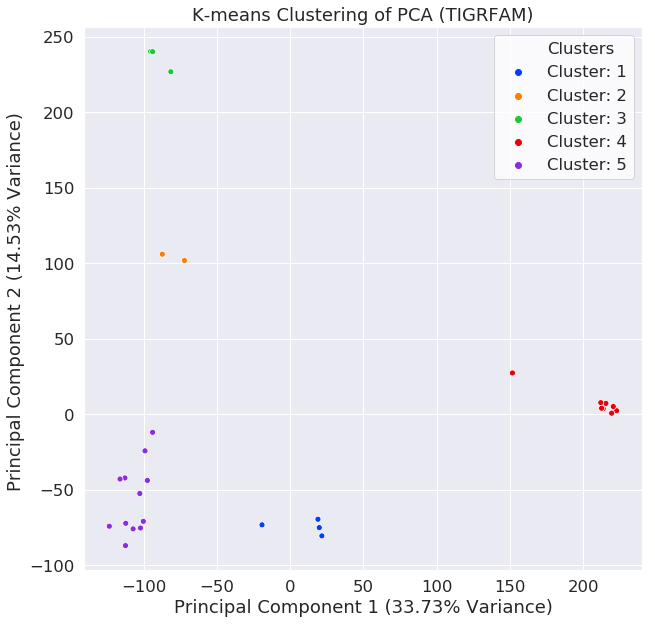

In [42]:
plt.figure(figsize = (10,10))
#sns.color_palette("Set2")
sns.scatterplot(palette="bright", data=pcaClusterDF2.sort_values(by=['Clusters']), x="principal component 1", y="principal component 2", hue="Clusters")
plt.title('K-means Clustering of PCA (TIGRFAM)')
plt.xlabel('Principal Component 1 (33.73% Variance)')
plt.ylabel('Principal Component 2 (14.53% Variance) ')
plt.legend(facecolor='white')
#plt.savefig("KMEANS_Module_functionality.pdf", bbox_inches='tight', dpi=300)
plt.show()

## Run Multiple PCAs for cluster functional analysis

In [46]:
ClusterColors = {"Cluster: 1":"#023eff", "Cluster: 2":"#ff7c00", "Cluster: 3":"#1ac938", "Cluster: 4":"#e8000b", "Cluster: 5":"#8b2be2"}

In [47]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pullFeatureImportance_clusters(dataframe):
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(columns=["Cluster"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cluster']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cluster']]], axis = 1).copy()
    
    return (pd.DataFrame(pca.components_,columns=pcaDF3.columns,index = ['PC-1','PC-2']))

In [48]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def runPCA3_cluster(dataframe, clusters , featureDF):
    
    featureDF_trim = featureDF.loc[clusters].copy()
    
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(["Cluster"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cluster']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cluster']]], axis = 1).copy()
    finalDf['Organism'] = list(dataframe.index)
    
    
    #Find out which cluster is the positive cluster
    testDF = finalDf.sort_values(by='principal component 1', ascending=False).copy()
    PosCluster = 'temp'
    for cluster in testDF[testDF['principal component 1'] > 0]['Cluster']:
        PosCluster = (cluster)
        break
        
    
    #Which cluster is the negative cluster
    negCluster = clusters.copy()
    negCluster.remove(PosCluster)
    
    
    featureImportanceDF_Pfam = pullFeatureImportance_clusters(dataframe).loc['PC-1']
    for feature in featureImportanceDF_Pfam.index:
        if abs(featureImportanceDF_Pfam.loc[feature]) >= 0.01:
            if featureImportanceDF_Pfam.loc[feature] > 0:
                featureDF_trim.at[PosCluster,feature] += abs(featureImportanceDF_Pfam.loc[feature])
            else:
                featureDF_trim.at[negCluster[0],feature] += abs(featureImportanceDF_Pfam.loc[feature])
        else:
            continue
    
    return(featureDF_trim)

In [49]:
cluster_1 = [x for x in pcaClusterDF2[pcaClusterDF2['Clusters']=='Cluster: 1'].index]
cluster_2 = [x for x in pcaClusterDF2[pcaClusterDF2['Clusters']=='Cluster: 2'].index]
cluster_3 = [x for x in pcaClusterDF2[pcaClusterDF2['Clusters']=='Cluster: 3'].index]
cluster_4 = [x for x in pcaClusterDF2[pcaClusterDF2['Clusters']=='Cluster: 4'].index]
cluster_5 = [x for x in pcaClusterDF2[pcaClusterDF2['Clusters']=='Cluster: 5'].index]

In [50]:
clusterDF = allMDF3.drop(columns=['Cohort']).copy()
clusterDF['Cluster'] = pcaClusterDF2['Clusters'].copy()
clusterDF.head()

,TIGR02778,TIGR00283,TIGR02100,TIGR02359,TIGR00224,TIGR00745,TIGR00260,TIGR04171,TIGR04342,TIGR01852,...,TIGR01819,TIGR01673,TIGR02366,TIGR01832,TIGR00100,TIGR01295,TIGR03494,TIGR01733,TIGR00967,Cluster
Bacterial_Species,,,,,,,,,,,,,,,,,,,,,
CRC_Module_0,-7.503506,-7.503506,3.648459,-7.503506,8.542272,8.539811,8.542272,-7.503506,-7.503506,8.927954,...,-7.503506,-7.503506,-7.503506,-7.503506,-7.503506,-7.503506,-7.503506,7.725033,8.542272,Cluster: 4
CRC_Module_1,-10.945334,-10.945334,2.278166,4.323762,4.748505,4.432463,5.119794,-10.945334,-10.945334,2.954899,...,-10.945334,3.606835,-10.945334,-0.433992,-10.945334,-10.945334,-10.945334,4.624636,5.294042,Cluster: 1
CRC_Module_2,-7.190143,-7.190143,-7.190143,-7.190143,8.966000,8.966000,8.966000,-7.190143,-7.190143,9.078533,...,-7.190143,-7.190143,-7.190143,-7.190143,-7.190143,-7.190143,-7.190143,5.188818,8.966000,Cluster: 4
CRC_Module_3,5.931263,-8.043830,-8.043830,-8.043830,7.827475,7.664796,8.202086,-8.043830,-8.043830,-8.043830,...,-8.043830,-8.043830,-8.043830,-8.043830,-8.043830,-8.043830,-8.043830,5.931263,8.202086,Cluster: 5
CRC_Module_4,-7.724917,-7.724917,-7.724917,6.974838,-7.724917,6.842263,8.183027,8.183027,8.483886,6.974838,...,-7.724917,-7.724917,-7.724917,-7.724917,-7.724917,-7.724917,-7.724917,8.735966,8.830864,Cluster: 2


In [51]:
clusterFeatureDF = pd.DataFrame(index=['Cluster: 1', 'Cluster: 2','Cluster: 3','Cluster: 4','Cluster: 5'], columns=clusterDF.drop(columns=['Cluster']).columns).fillna(0.0)
clusterFeatureDF.head()

,TIGR02778,TIGR00283,TIGR02100,TIGR02359,TIGR00224,TIGR00745,TIGR00260,TIGR04171,TIGR04342,TIGR01852,...,TIGR04366,TIGR01819,TIGR01673,TIGR02366,TIGR01832,TIGR00100,TIGR01295,TIGR03494,TIGR01733,TIGR00967
Cluster: 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cluster: 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cluster: 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cluster: 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cluster: 5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
c_1_2 = runPCA3_cluster(clusterDF.loc[cluster_1+cluster_2], ['Cluster: 1', 'Cluster: 2'], clusterFeatureDF)
c_1_3 = runPCA3_cluster(clusterDF.loc[cluster_1+cluster_3], ['Cluster: 1', 'Cluster: 3'], clusterFeatureDF)
c_1_4 = runPCA3_cluster(clusterDF.loc[cluster_1+cluster_4], ['Cluster: 1', 'Cluster: 4'], clusterFeatureDF)
c_1_5 = runPCA3_cluster(clusterDF.loc[cluster_1+cluster_5], ['Cluster: 1', 'Cluster: 5'], clusterFeatureDF)

c_2_3 = runPCA3_cluster(clusterDF.loc[cluster_2+cluster_2], ['Cluster: 2', 'Cluster: 3'], clusterFeatureDF)
c_2_4 = runPCA3_cluster(clusterDF.loc[cluster_2+cluster_2], ['Cluster: 2', 'Cluster: 4'], clusterFeatureDF)
c_2_5 = runPCA3_cluster(clusterDF.loc[cluster_2+cluster_2], ['Cluster: 2', 'Cluster: 5'], clusterFeatureDF)

c_3_4 = runPCA3_cluster(clusterDF.loc[cluster_3+cluster_4], ['Cluster: 3', 'Cluster: 4'], clusterFeatureDF)
c_3_5 = runPCA3_cluster(clusterDF.loc[cluster_3+cluster_5], ['Cluster: 3', 'Cluster: 5'], clusterFeatureDF)

c_4_5 = runPCA3_cluster(clusterDF.loc[cluster_4+cluster_5], ['Cluster: 4', 'Cluster: 5'], clusterFeatureDF)

In [53]:
allClusterComparison = pd.concat([c_1_2,c_1_3,c_1_4,c_1_5,c_2_3,c_2_4,c_2_5,c_3_4,c_3_5,c_4_5])
clusterComp = allClusterComparison.replace(0.0, np.nan).dropna(axis=1, thresh=1).fillna(0.0)
FinalCluserComp = clusterComp.groupby(clusterComp.index).sum().copy()